### ReAct Agent Architecture

#### Aim
This is the intuition behind ReAct, a general agent architecture.

1. act - let the model call specific tools
2. observe - pass the tool output back to the model
3. reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [4]:
wiki.invoke("What is AGI?")

'Page: Artificial general intelligence\nSummary: Artificial general intelligence (AGI)—sometimes called human‑level intelligence AI—is a type of artificial intelligence that would match or surpass human capabilities across virtually all cognitive tasks.\nSome researchers argue that state‑of‑the‑art large language models (LLMs) already exhibit signs of AGI‑level capability, while others maintain that genuine AGI has not yet been achieved. Beyond AGI, artificial superintelligence (ASI) would outperfo'

In [5]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"


In [6]:
### Custom Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[arxiv,wiki,add,multiply,divide]

In [7]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\rajpu\AppData\Local\Temp\ipykernel_15784\3584238.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [8]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'Top 5 AI trends in March 2025: AI agents, smarter supply ...',
  'url': 'https://www.neudesic.com/blog/top-5-ai-trends-march-2025/',
  'content': 'March 2025 has brought a fresh wave of AI innovations that go beyond theoretical breakthroughs and translate directly into real-world impact. From OpenAI’s newly released tools for building AI agents to Microsoft’s external knowledge integration approach, this month’s highlights underscore how artificial intelligence is evolving in ways that matter today, not just tomorrow. Whether it’s optimizing supply chains, pushing the limits of robotics, or making AI systems smarter and more trustworthy, [...] these developments are shaping the landscape of technology and business alike. [...] Below, we delve into five top AI trends from March 2025 and explore the practical ways they’re changing industries—from retail to robotics—and setting the stage for what’s ahead. \n\n## 1. OpenAI Releases New Tools for Building AI Agents',
  'score': 

In [9]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily,add,divide,multiply]

In [10]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen/qwen3-32b")
response = llm.invoke("Write a code for binary search in c++")

In [11]:
response

AIMessage(content='<think>\nOkay, I need to write a C++ code for binary search. Let me think about how binary search works. Binary search is an efficient algorithm for finding an item in a sorted list. It works by repeatedly dividing the search interval in half. \n\nFirst, I should make sure that the input array is sorted. Otherwise, binary search won\'t work correctly. So, the array needs to be sorted in ascending order. \n\nThe basic steps are:\n1. Initialize two pointers, low and high, to the start and end of the array.\n2. While low is less than or equal to high, calculate the mid-point.\n3. Compare the mid element with the target value.\n   - If the target is equal to the mid element, return the index.\n   - If the target is less than the mid element, adjust high to mid - 1.\n   - If the target is greater, adjust low to mid + 1.\n4. If the element is not found, return -1 or some indication.\n\nLet me think about the parameters. The function should take the array, the target value,

In [12]:
llm_with_tools = llm.bind_tools(tools)

In [13]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001903A287830>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001903B7E43B0>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'arxiv', 'description': 'A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering, and Economics from scientific articles on arxiv.org. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts,

In [14]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. Let me check the available functions.\n\nThe tools provided include arxiv, wikipedia, tavily_search_results_json, add, divide, multiply. The arxiv is for scientific papers, wikipedia for general knowledge, and tavily_search_results_json is for current events. Since the user is asking about recent news, which is likely to be current events, the tavily_search_results_json seems appropriate. The other math functions don\'t apply here. So I should use tavily_search_results_json with the query "recent AI news".\n', 'tool_calls': [{'id': '3ncn9g7cq', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 156, 'prompt_tokens': 637, 'total_tokens': 793, 'completion_time': 0.25918262, 'prompt_time': 0.027015448, 'queue_time': 0

In [15]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI News'},
  'id': 'cmjtjtpdk',
  'type': 'tool_call'}]

In [16]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

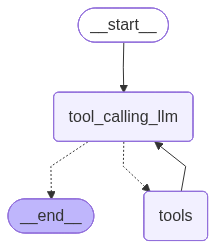

In [17]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025,add 5 plus 5 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025,add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (bcng3qs2p)
 Call ID: bcng3qs2p
  Args:
    query: top 10 recent AI news March 3rd 2025
  add (x5s3ryyfs)
 Call ID: x5s3ryyfs
  Args:
    a: 5
    b: 5
  multiply (tt01rkbch)
 Call ID: tt01rkbch
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Top 5 AI trends in March 2025: AI agents, smarter supply chains ...", "url": "https://www.neudesic.com/blog/top-5-ai-trends-march-2025/", "content": "March 2025 has brought a fresh wave of AI innovations that go beyond theoretical breakthroughs and translate directly into real-world impact. From OpenAI’s newly released tools for building AI agents to 

#### MemorySaver
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [19]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")

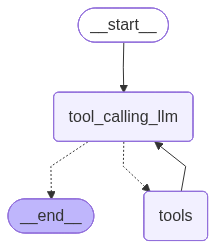

In [20]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
## Specify the thread

config = {"configurable":{"thread_id":"1"}}

## Specify an Input
messages = [HumanMessage(content="Add 4 and 5")]

messages=graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 4 and 5
================================== Ai Message ==================================
Tool Calls:
  add (a891vk8hf)
 Call ID: a891vk8hf
  Args:
    a: 4
    b: 5
================================= Tool Message =================================
Name: add

9
================================== Ai Message ==================================

The sum of 4 and 5 is 9.


In [24]:
## Specify an Input
messages = [HumanMessage(content="add that number to 60")]

messages=graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 4 and 5
================================== Ai Message ==================================
Tool Calls:
  add (a891vk8hf)
 Call ID: a891vk8hf
  Args:
    a: 4
    b: 5
================================= Tool Message =================================
Name: add

9
================================== Ai Message ==================================

The sum of 4 and 5 is 9.
================================ Human Message =================================

add that number to 60
================================== Ai Message ==================================
Tool Calls:
  add (1qn0ez3hr)
 Call ID: 1qn0ez3hr
  Args:
    a: 9
    b: 60
================================= Tool Message =================================
Name: add

69
================================== Ai Message ==================================

The sum of 9 and 60 is 69.


In [25]:
## Specify an Input
messages = [HumanMessage(content="multiply the number by 24")]

messages=graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 4 and 5
================================== Ai Message ==================================
Tool Calls:
  add (a891vk8hf)
 Call ID: a891vk8hf
  Args:
    a: 4
    b: 5
================================= Tool Message =================================
Name: add

9
================================== Ai Message ==================================

The sum of 4 and 5 is 9.
================================ Human Message =================================

add that number to 60
================================== Ai Message ==================================
Tool Calls:
  add (1qn0ez3hr)
 Call ID: 1qn0ez3hr
  Args:
    a: 9
    b: 60
================================= Tool Message =================================
Name: add

69
================================== Ai Message ==================================

The sum of 9 and 60 is 69.
================================ Human Message =================================

